# 1. Import and Install Dependencies

In [10]:
# !pip install tensorflow==2.7.1 tensorflow-gpu==2.7.1 opencv-python==4.5.5.64 mediapipe==0.10.5 scikit-learn==0.24.2 numpy==1.19.5 matplotlib      

In [2]:
import cv2
import numpy as np
import os

import mediapipe as mp

# 2. Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [6]:
def draw_styled_landmarks(image, results):

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                             ) 

In [30]:
cap = cv2.VideoCapture(1) ### chage to your device usually 0
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        # print(frame.shape)
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        # # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# draw_landmarks(frame, results)

# 3. Extract Keypoint Values

In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

# 4. Setup Folders for Collection

In [ ]:
# Path for exported data, numpy arrays
from pathlib import Path
DATA_PATH = Path(r'DATA1') ### change your path

# Actions that we try to detect
# actions = np.array(['null','besm allah' , 'alsalam alekom' , 'alekom salam' , 'aslan w shlan' , 'me',
#                     'age','alhamdulilah' , 'bad' , 'how are you' , 'friend' ,
#                     'good' , 'happy' , 'you' , 'my name is' , 'no' , 
#                     'or' , 'taaban' , 'what' , 'where' , 'yes' ,
#                     'look' , 'said' , 'walking' , 'did not hear' , 'remind me',
#                     'eat' , 'bayt' , 'hospital' , 'run' , 'sleep',
#                     'think' , 'tomorrow' , 'yesterday' , 'today' , 'when',
#                     'dhuhr' , 'sabah' , 'university' , 'kuliyah' ,'night',
#                     'a3ooth bellah' , 'danger' , 'enough' , 'hot' , 'mosque' , 'surprise' , 'tard' , 
#                     'big' , 'clean' , 'dirty' , 'fire' , 'give me' , 'sho dakhalak' , 'small' , 
#                     'help' , 'same' , 'hour' , 'important' , 'ok' , 'please' , 'want' ,
#                     'riyadah' , 'sallah' , 'telephone' , 'hamam' , 'water' , 'eid'
#                    ])

actions = np.array(['null','besm allah' , 'alsalam alekom' , 'alekom salam' , 'ahlan w shlan' , 'me',
                    'age','alhamdulilah' , 'bad' , 'how are you' , 'friend' ,
                    'good' , 'happy' , 'you' , 'my name is' , 'no' , 
                    'or' , 'taaban' , 'what' , 'where' , 'yes', 'look' , 'said' , 'walking' , 'did not hear' ,
                      'remind me', 'eat' , 'bayt' , 'hospital' , 'run' , 'sleep',
                       'think' , 'tomorrow' , 'yesterday' , 'today' , 'when','dhuhr' , 'sabah' , 'university' , 'kuliyah' ,'night',])


# Thirty videos worth of data
no_sequences = 10

# Videos are going to be 30 frames in length
sequence_length = 45

# Folder start
start_folder = 0

In [9]:
for action in actions: 
    
    for sequence in range(start_folder,no_sequences+1):
        try: 
            os.makedirs(Path.joinpath(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [47]:
cap = cv2.VideoCapture(0) ### chage to your device usually 0
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences + 1):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(3000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = Path.joinpath(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

        cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
        cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        cv2.waitKey(3000)
    cap.release()
    cv2.destroyAllWindows()


I0000 00:00:1736345292.780685   65453 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3
W0000 00:00:1736345292.828325  189157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1736345292.842201  189156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1736345292.843696  189155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1736345292.843698  189160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1736345292.843727  189159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

In [44]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label:num for num, label in enumerate(actions)}

In [13]:
label_map

{'null': 0,
 'besm allah': 1,
 'alsalam alekom': 2,
 'alekom salam': 3,
 'ahlan w shlan': 4,
 'me': 5,
 'age': 6,
 'alhamdulilah': 7,
 'bad': 8,
 'how are you': 9,
 'friend': 10,
 'good': 11,
 'happy': 12,
 'you': 13,
 'my name is': 14,
 'no': 15,
 'or': 16,
 'taaban': 17,
 'what': 18,
 'where': 19,
 'yes': 20,
 'look': 21,
 'said': 22,
 'walking': 23,
 'did not hear': 24,
 'remind me': 25,
 'eat': 26,
 'bayt': 27,
 'hospital': 28,
 'run': 29,
 'sleep': 30,
 'think': 31,
 'tomorrow': 32,
 'yesterday': 33,
 'today': 34,
 'when': 35,
 'dhuhr': 36,
 'sabah': 37,
 'university': 38,
 'kuliyah': 39,
 'night': 40}

In [39]:
def normalize_landmarks(landmarks, epsilon=1e-6):
    num_points = len(landmarks) // 3
    landmarks = landmarks.reshape(num_points, 3)

    # Use wrist as anchor for hands and midpoint of hips for pose
    if num_points == 33:  # Pose
        anchor = landmarks[23]  # Left hip
        reference_dist = np.linalg.norm(landmarks[11] - landmarks[12])  # Shoulder width
    elif num_points == 21:  # Hands
        anchor = landmarks[0]  # Wrist
        reference_dist = np.linalg.norm(landmarks[5] - landmarks[17])  # Palm width
    else:
        return landmarks.flatten()  # Return unchanged for unexpected data

    # Handle potential zero or small reference distance
    if reference_dist < epsilon:
        return np.zeros_like(landmarks.flatten())  # Return zeroed-out array for invalid frames

    # Translate (center around anchor)
    landmarks -= anchor

    # Scale (normalize distances)
    landmarks /= reference_dist

    return landmarks.flatten()


sequences, labels = [], []
skip = 5
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))):

        try:
            if count < skip:
                count +=1
                continue
            sequence = sequence.astype(int)
            window = []
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
                normalized_res = np.concatenate([
                    normalize_landmarks(res[:33*4]),  # Pose landmarks
                    normalize_landmarks(res[33*4:33*4 + 21*3]),  # Left hand landmarks
                    normalize_landmarks(res[33*4 + 21*3:])  # Right hand landmarks
                ])
                window.append(normalized_res)
            sequences.append(window[skip:])
            labels.append(label_map[action])
        except Exception as e:
            print(f"Error in sequence {sequence}: {e}")

Error in sequence .ipynb_checkpoints: invalid literal for int() with base 10: '.ipynb_checkpoints'
Error in sequence .ipynb_checkpoints: invalid literal for int() with base 10: '.ipynb_checkpoints'
Error in sequence .ipynb_checkpoints: invalid literal for int() with base 10: '.ipynb_checkpoints'
Error in sequence .ipynb_checkpoints: invalid literal for int() with base 10: '.ipynb_checkpoints'
Error in sequence .DS_Store: invalid literal for int() with base 10: '.DS_Store'
Error in sequence ._80: invalid literal for int() with base 10: '._80'
Error in sequence ._81: invalid literal for int() with base 10: '._81'
Error in sequence ._82: invalid literal for int() with base 10: '._82'
Error in sequence ._83: invalid literal for int() with base 10: '._83'
Error in sequence ._84: invalid literal for int() with base 10: '._84'
Error in sequence ._85: invalid literal for int() with base 10: '._85'
Error in sequence ._86: invalid literal for int() with base 10: '._86'
Error in sequence ._87: in

In [40]:
np.array(sequences).shape

(4099, 40, 258)

In [41]:
np.array(labels).shape

(4099,)

In [42]:
X = np.array(sequences)

In [43]:
X.shape

(4099, 40, 258)

In [44]:
y = to_categorical(labels).astype(int)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

# 7. Build and Train LSTM Neural Network

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
import tensorflow as tf

In [47]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
call_backs = [tb_callback, ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=10, 
                                  verbose=0, )]

In [48]:
model = Sequential()
model.add(Input(shape=(40, 258)))  # define shape here
model.add(LSTM(258, return_sequences=True, activation='tanh'))
model.add(LSTM(258, return_sequences=False, activation='tanh'))
model.add(Dense(258, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [49]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [50]:
tf.keras.backend.clear_session()
history = model.fit(X, y,validation_data=(X_val, y_val), epochs=100, callbacks=call_backs)
tf.keras.backend.clear_session()

Epoch 1/100


129/129 [==============================] - 11s 63ms/step - loss: 2.3479 - categorical_accuracy: 0.3528 - val_loss: 1.6827 - val_categorical_accuracy: 0.5146 - lr: 0.0010
Epoch 2/100
129/129 [==============================] - 7s 58ms/step - loss: 1.3434 - categorical_accuracy: 0.6009 - val_loss: 0.9293 - val_categorical_accuracy: 0.7610 - lr: 0.0010
Epoch 3/100
129/129 [==============================] - 7s 58ms/step - loss: 0.8848 - categorical_accuracy: 0.7373 - val_loss: 0.8818 - val_categorical_accuracy: 0.7293 - lr: 0.0010
Epoch 4/100
129/129 [==============================] - 7s 58ms/step - loss: 0.6577 - categorical_accuracy: 0.8078 - val_loss: 0.5649 - val_categorical_accuracy: 0.8439 - lr: 0.0010
Epoch 5/100
129/129 [==============================] - 8s 58ms/step - loss: 0.5740 - categorical_accuracy: 0.8261 - val_loss: 0.4664 - val_categorical_accuracy: 0.8463 - lr: 0.0010
Epoch 6/100
129/129 [==============================] - 8s 59ms/step - loss: 0.4152 - categor

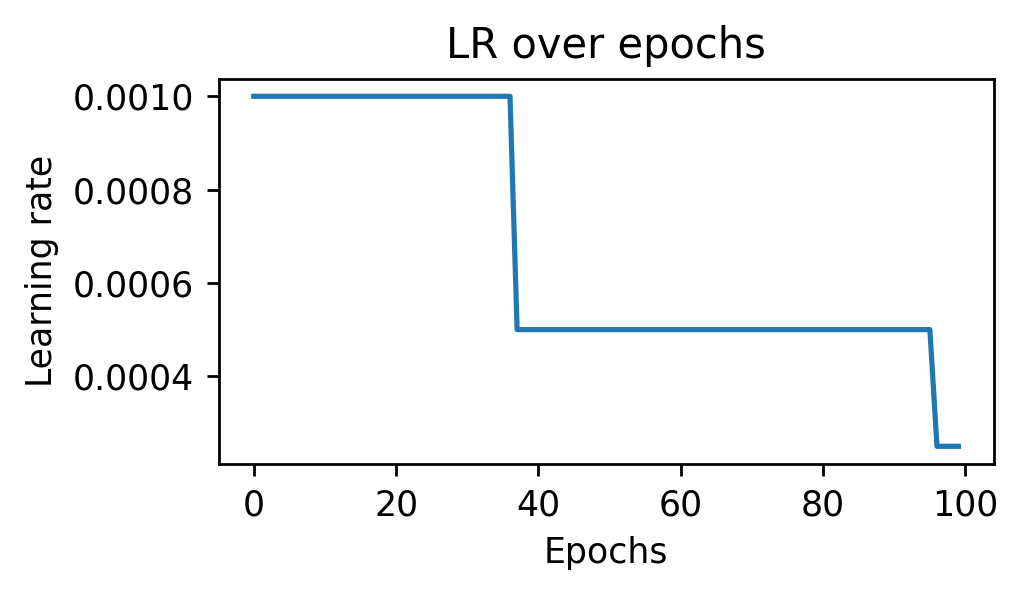

In [51]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=250, figsize=(4,2))
plt.plot(history.history['lr'])
plt.title('LR over epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
fig.savefig('lr_epochs.png')
plt.show()

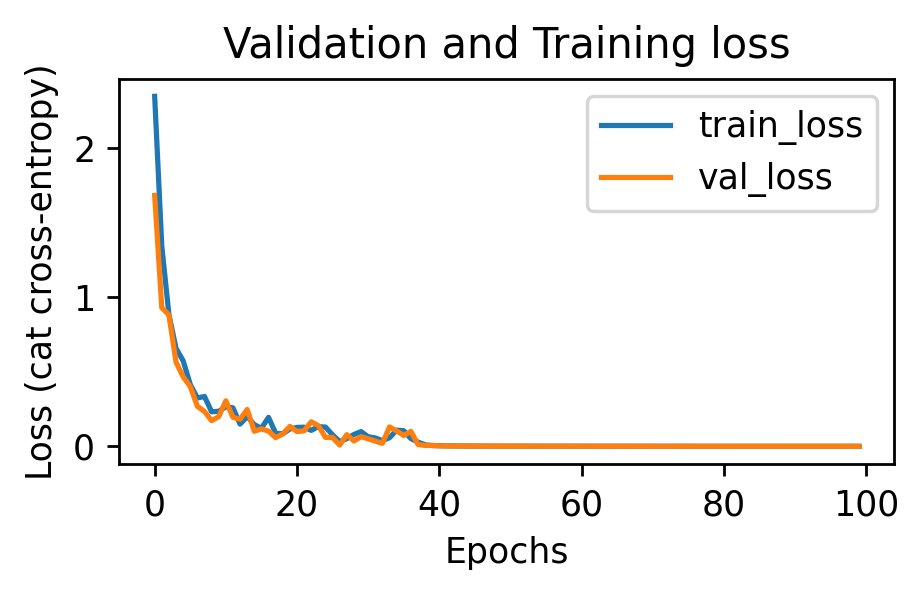

In [52]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=250, figsize=(4,2))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.title('Validation and Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (cat cross-entropy)')
fig.savefig('val_train_loss.png')
plt.show()

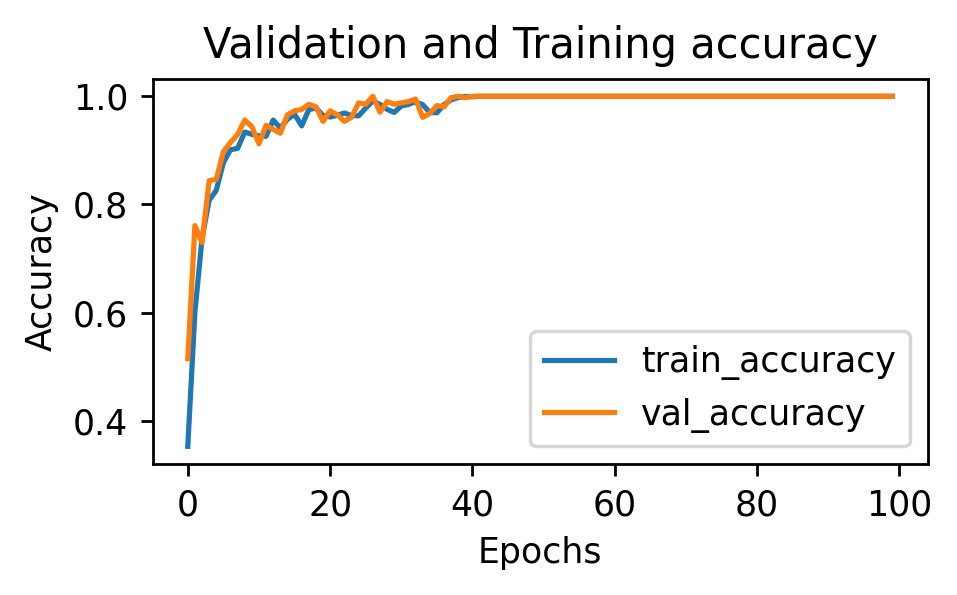

In [53]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=250, figsize=(4,2))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.title('Validation and Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
fig.savefig('val_train_accuracy.png')
plt.show()

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 258)           533544    
                                                                 
 lstm_1 (LSTM)               (None, 258)               533544    
                                                                 
 dense (Dense)               (None, 258)               66822     
                                                                 
 dense_1 (Dense)             (None, 128)               33152     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 41)                2665      
                                                                 
Total params: 1177983 (4.49 MB)
Trainable params: 117798

In [ ]:
## train on all data
tf.keras.backend.clear_session()
history = model.fit(X, y, epochs=60, callbacks=[tb_callback])
tf.keras.backend.clear_session()

Epoch 1/60
77/77 [==============================] - 6s 28ms/step - loss: 2.8737 - categorical_accuracy: 0.2643
Epoch 2/60
77/77 [==============================] - 2s 29ms/step - loss: 1.8820 - categorical_accuracy: 0.5283
Epoch 3/60
77/77 [==============================] - 2s 28ms/step - loss: 1.3233 - categorical_accuracy: 0.6710
Epoch 4/60
77/77 [==============================] - 2s 30ms/step - loss: 1.0274 - categorical_accuracy: 0.7519
Epoch 5/60
77/77 [==============================] - 2s 29ms/step - loss: 0.7168 - categorical_accuracy: 0.8341
Epoch 6/60
77/77 [==============================] - 2s 30ms/step - loss: 0.5675 - categorical_accuracy: 0.8817
Epoch 7/60
77/77 [==============================] - 2s 28ms/step - loss: 0.5454 - categorical_accuracy: 0.8613
Epoch 8/60
77/77 [==============================] - 2s 29ms/step - loss: 0.4500 - categorical_accuracy: 0.8857
Epoch 9/60
77/77 [==============================] - 3s 34ms/step - loss: 0.3683 - categorical_accuracy: 0.9170
E

# 8. Make Predictions

In [56]:
res = model.predict(X_val)

13/13 [==============================] - 1s 24ms/step


In [57]:
actions[np.argmax(res[0])]

'alsalam alekom'

In [59]:
actions[np.argmax(y_val[0])]

'alsalam alekom'

# 9. Save Weights

In [60]:
model.save('action_skip5_40_new.h5')

c:\Users\MANIA\Desktop\grad_project\winenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
model = load_model('./action_skip5_40_new.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [34]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [35]:
yhat = model.predict(X_test)

6/6 [==============================] - 1s 12ms/step


In [36]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [37]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[178,   1],
        [  0,  10]],

       [[179,   0],
        [  1,   9]],

       [[180,   1],
        [  0,   8]],

       [[178,   0],
        [  1,  10]],

       [[174,   0],
        [  0,  15]],

       [[183,   0],
        [  0,   6]],

       [[178,   0],
        [  0,  11]],

       [[175,   0],
        [  0,  14]],

       [[184,   0],
        [  0,   5]],

       [[181,   0],
        [  0,   8]],

       [[184,   1],
        [  0,   4]],

       [[177,   0],
        [  0,  12]],

       [[172,   0],
        [  0,  17]],

       [[184,   0],
        [  0,   5]],

       [[182,   0],
        [  1,   6]],

       [[180,   0],
        [  0,   9]],

       [[183,   0],
        [  0,   6]],

       [[180,   0],
        [  0,   9]],

       [[181,   0],
        [  0,   8]],

       [[180,   0],
        [  0,   9]],

       [[184,   0],
        [  0,   5]]], dtype=int64)

In [38]:
accuracy_score(ytrue, yhat)

0.9841269841269841

# 11. Test in Real Time

In [61]:
from scipy import stats

In [62]:
colors = [(245,117,16), (117,245,16), (16,117,245),(16,137,205), (16,17,245), (122,147,45), (156,117,240)]*15
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [44]:
# colors = [(245,117,16), (117,245,16), (16,117,245),(16,137,205), (16,17,245), (122,147,45), (156,117,240)]*15

# def prob_viz(res, actions, input_frame, colors):
#     output_frame = input_frame.copy()
#     column_width = 200  # Adjust the width between columns
#     for num, prob in enumerate(res):
#         # Determine the column and row for the current word
#         column = num // 20  # Divide into columns (0 for first, 1 for second)
#         row = num % 20  # Index within the column
        
#         # Calculate x and y positions for rectangles and text
#         x_start = column * column_width
#         y_start = 60 + row * 40
#         x_end = x_start + int(prob * 100)
#         y_end = y_start + 30
        
#         # Draw the probability bar
#         cv2.rectangle(output_frame, (x_start, y_start), (x_end, y_end), colors[num], -1)
        
#         # Draw the action label
#         cv2.putText(output_frame, actions[num], (x_start, y_end - 5), 
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
        
#     return output_frame



In [45]:
cap.release()
cv2.destroyAllWindows()

In [63]:
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        # Determine the column (0 or 1) and row
        col = num % 2
        row = num // 2

        # Adjust x-offset and y-offset for two columns
        x_offset = col * 320  # Column spacing (width of each column)
        y_offset = 60 + row * 40  # Row spacing

        # Draw the rectangles and text
        cv2.rectangle(output_frame, 
                      (x_offset, y_offset), 
                      (x_offset + int(prob * 300), y_offset + 30), 
                      colors[num], -1)
        cv2.putText(output_frame, 
                    actions[num], 
                    (x_offset + 10, y_offset + 25),  # Adjusted to align with the rectangles
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

    return output_frame





In [64]:
# 

In [65]:
sequence = []
sentence = []
predictions = []
threshold = 0.7  # Updated threshold
skip_frames = 0  # Counter for skipping frames

def normalize_landmarks(landmarks, epsilon=1e-6):
    num_points = len(landmarks) // 3
    landmarks = landmarks.reshape(num_points, 3)

    if num_points == 33:  # Pose
        anchor = landmarks[23]  # Left hip
        reference_dist = np.linalg.norm(landmarks[11] - landmarks[12])  # Shoulder width
    elif num_points == 21:  # Hands
        anchor = landmarks[0]  # Wrist
        reference_dist = np.linalg.norm(landmarks[5] - landmarks[17])  # Palm width
    else:
        return landmarks.flatten()  # Return unchanged for unexpected data

    if reference_dist < epsilon:
        return np.zeros_like(landmarks.flatten())

    landmarks -= anchor
    landmarks /= reference_dist

    return landmarks.flatten()

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    normalized_pose = normalize_landmarks(pose[:33*4])  # ignore visibility in normalization
    normalized_lh = normalize_landmarks(lh)
    normalized_rh = normalize_landmarks(rh)
    
    return np.concatenate([normalized_pose, normalized_lh, normalized_rh])

cap = cv2.VideoCapture(1)
# cap.set(cv2.CAP_PROP_FPS, 30)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv2.resize(frame, (640*2, 480*2))
        frame = cv2.flip(frame, 1)
        image, results = mediapipe_detection(frame, holistic)

        draw_styled_landmarks(image, results)

        if skip_frames > 0:
            skip_frames -= 1
            cv2.imshow('OpenCV Feed', image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
            continue

        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-40:]

        if len(sequence) == 40:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

            if np.max(res) > threshold:
                predicted_class = np.argmax(res)
                predictions.append(predicted_class)

                if np.unique(predictions[-10:])[0] == predicted_class:
                    if len(sentence) == 0 or actions[predicted_class] != sentence[-1]:
                        sentence.append(actions[predicted_class])
                        skip_frames = 15  # Skip next 5 frames after valid prediction
            else:
                predicted_class = 0  # Null class
                predictions.append(predicted_class)

            image = prob_viz(res, actions, image, colors)

            if len(sentence) > 5:
                sentence = sentence[-5:]

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 19ms/step


KeyboardInterrupt: 

In [66]:
cap.release()
cv2.destroyAllWindows()
